# SCOOTR Tutorial

In this tutorial, we will examine our newest tool, SCOOTR. SCOOTR blends together UGW and UCOOT to incentivise sample alignments that are  informed by both feature correspondence and local geometry. We will again use the CITEseq dataset from earlier tutorials, with the goal of recovering the underlying 1-1 alignment of the 1000 samples by considering expression and antibody data separately.

```{tip}
If you have not yet configured a SCOOTR directory of some kind, see our installation instructions markdown. Once you complete those steps or set up your own virual environment, continue on here.

If you aren't sure what any of the parameters for setting up a SCOOTR object mean, try our setup tutorial for getting used to using the tool.

If you are looking for more detail on what the parameters of the alignment do in practice, start by visiting our UGW, UCOOT, and fused formulation tutorials. We will draw on all of these when examining SCOOTR.

If you are unsure what some of the notation means throughout the rest of this document, try reading our optimal transport theory section to get more comfortable.

If you already know how to use SCOOTR, continue on to the next chapter: our explorations of how SCOOTR can be applied!
```

### Preprocessing

As usual, we set up PyTorch (for UCOOT/UGW, not SCOOTR)

In [1]:
import torch
print('Torch version: {}'.format(torch.__version__))
print('CUDA available: {}'.format(torch.cuda.is_available()))
print('CUDA version: {}'.format(torch.version.cuda))
print('CUDNN version: {}'.format(torch.backends.cudnn.version()))

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
torch.backends.cudnn.benchmark=True

Torch version: 2.0.1
CUDA available: False
CUDA version: None
CUDNN version: None


To begin, we will load in our preprocessed data. If you would like to preprocess the data in your own way, you can download the raw files for this dataset by running "sh download_scripts/CITEseq_download.sh" from the root of your SCOOTR directory. They will be loaded into the same folder as the preprocessed datasets.

In [2]:
%%capture
import src.scootr as scoot
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import umap
from sklearn.preprocessing import normalize
plt.rcParams['font.family'] = 'Helvetica Neue'

X_raw = sc.read_csv("./data/CITEseq/citeseq_adt_normalized_1000cells.csv")
y_raw = sc.read_csv("./data/CITEseq/citeseq_rna_normalizedFC_1000cells.csv")
x_feat_labels=["CD11a","CD11c","CD123","CD127-IL7Ra","CD14","CD16","CD161","CD19","CD197-CCR7","CD25","CD27","CD278-ICOS","CD28","CD3","CD34","CD38","CD4","CD45RA","CD45RO","CD56","CD57","CD69","CD79b","CD8a","HLA.DR"]
y_feat_labels=["ITGAL","ITGAX","IL3RA","IL7R","CD14","FCGR3A","KLRB1","CD19","CCR7","IL2RA","CD27","ICOS","CD28","CD3E","CD34","CD38","CD4","PTPRC","PTPRC","NCAM1","B3GAT1","CD69","CD79B","CD8A","HLA-DRA"] 
samp_labels = ['Cell {0}'.format(x) for x in range(X_raw.shape[1])]

From here, we can load our data into usable DataFrames, as in prior tutorials.

In [12]:
X_full_annotated = pd.DataFrame(normalize(normalize(X_raw.X, norm='l2', axis=1).transpose(), norm='l2', axis=1))
X_full_annotated.index, X_full_annotated.columns = samp_labels, x_feat_labels
y_full_annotated = pd.DataFrame(normalize(y_raw.transpose().X, norm='l2', axis=1))
y_full_annotated.index, y_full_annotated.columns = samp_labels, y_feat_labels

X_full = X_full_annotated.to_numpy()
y_full = y_full_annotated.to_numpy()

X_annotated = X_full_annotated.iloc[:,0:10]
y_annotated = y_full_annotated.iloc[:,0:10]

X = X_annotated.to_numpy()
y = y_annotated.to_numpy()

In order to keep our objective in mind, let's look at the UMAP/PCA of each domain pre-alignment one last time:

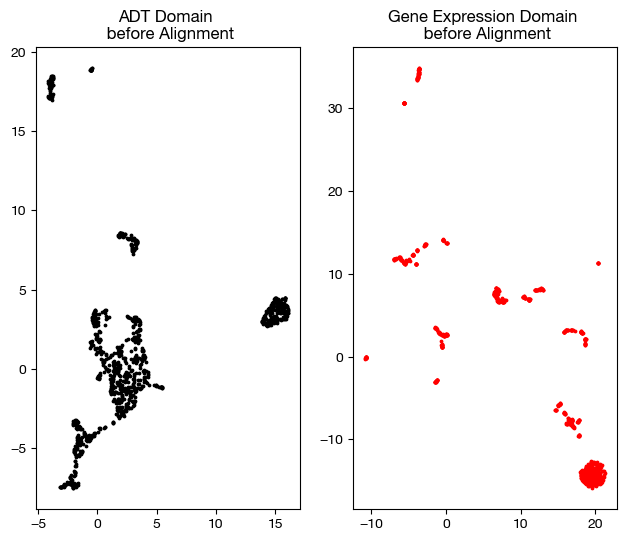

In [86]:
um = umap.UMAP(random_state=0)

originalX_um=um.fit_transform(X)
originaly_um=um.fit_transform(y)

#Visualization of the global geometry
fig, (ax1, ax2)= plt.subplots(1,2, figsize=(12, 5))
ax1.scatter(originalX_um[:,0], originalX_um[:,1], c="k", s=5)
ax1.set_title("ADT Domain \n before Alignment")
ax2.scatter(originaly_um[:,0], originaly_um[:,1], c="b", s=5)
ax2.set_title("Gene Expression Domain \n before Alignment")
plt.show()

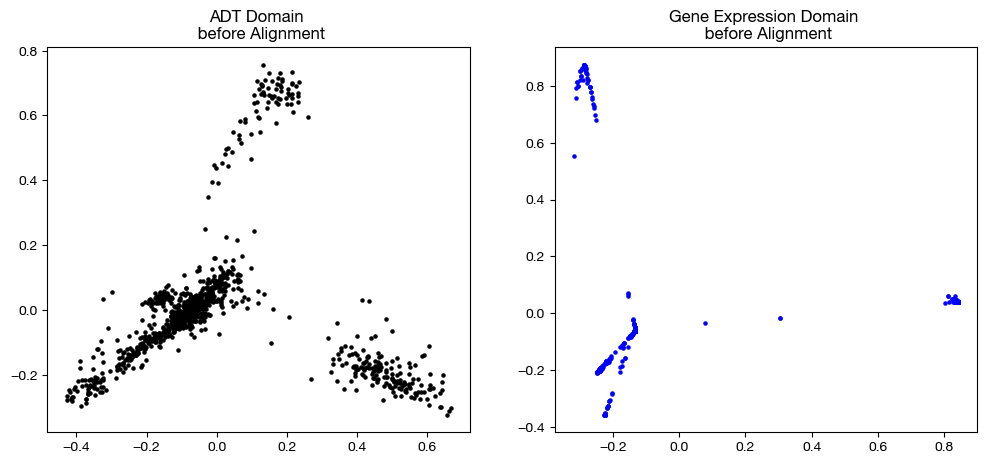

In [89]:
from sklearn.decomposition import PCA

pca=PCA(n_components=2)

originalX_pca=pca.fit_transform(X)
originaly_pca=pca.fit_transform(y)

#Visualization of the global geometry
fig, (ax1, ax2)= plt.subplots(1,2, figsize=(12,5))
ax1.scatter(originalX_pca[:,0], originalX_pca[:,1], c="k", s=5)
ax1.set_title("ADT Domain \n before Alignment")
ax2.scatter(originaly_pca[:,0], originaly_pca[:,1], c="b", s=5)
ax2.set_title("Gene Expression Domain \n before Alignment")
plt.show()

### Default SCOOTR

Next, we can instantiate a SCOOTR object to begin aligning our data.

```{note}
Unlike UCOOT and UGW, SCOOTR allows us to use conditional gradient descent to solve sample alignments, and earth mover's distance to solve either sample or feature alignments. These OT algorithms (that take place at each inner process of a BCD iteration) converge at different speeds; we recommend following the nits_uot guidelines below.
```

In [37]:
scootr_sink = scoot.SCOOTR(nits_bcd=10, eval_bcd=1)
scootr_cg = scoot.SCOOTR(nits_bcd=10, nits_uot=500, eval_bcd=1)
scootr_emd = scoot.SCOOTR(nits_bcd=10, nits_uot=1e7, eval_bcd=1)

From here, we can begin by establishing pairwise distance matrices for our domains, as per the UGW tutorial:

In [30]:
# knn connectivity distance
Dx_knn = scootr_sink.knn_dist(X, k=10, mode='connectivity')
Dy_knn = scootr_sink.knn_dist(y, k=10, mode='connectivity')

Now that we are all set up to run an alignment between $X$ and $y$, we will pause for a moment to examine what SCOOTR is trying to do. As we did with UGW and UCOOT, let's examine the objective function that SCOOTR is hoping to minimize. First, recall our UGW objective function:

$GW(\pi_s) = L_{GW}(D(x_i, x_j), D(y_k, y_l)) \cdot \pi_{s_{ij}} \cdot \pi_{s_{kl}}$ for all samples $i, j$ in $X$ and $k, l$ in $y$. Recall that $L_{GW}$ is euclidean distance for our purposes. Now, we re-examine the UCOOT objective function:

$COOT(\pi_s, \pi_f) = L_{COOT}(X_{ij}, y_{kl}) \cdot \pi_{s_{ik}} \cdot \pi_{f_{jl}}$ for all samples $i$ in $X$, features $j$ in $X$, samples $k$ in $y$, and features $l$ in $y$. Again, $L_{COOT}$ is euclidean distance for our purposes. Given these two functions, our SCOOTR objective function is as follows:

$\alpha GW(\pi_s) + (1 - \alpha) COOT(\pi_s, \pi_f)$

```{warning}
Note that we have a new hyperparameter $\alpha$ – this is NOT the same $\alpha$ we used in the fused formulation. In this case, $\alpha$ trades off how much we use GW versus COOT in our optimization procedure.
```

This SCOOTR objective function allows us to continue employing BCD, as we can also frame it as follows:

$\langle \alpha L_{GW}(D_X, D_y) \otimes \pi_s + (1 - \alpha) L_{COOT}(X, y) \otimes \pi_f, \pi_s \rangle$ where $D_X$ and $D_y$ are the distance matrices we constructed earlier.

As seen in this function, SCOOTR takes the shape of a COOT problem, albeit with a more complicated tensor on the left side of the inner product.

SCOOTR allows us to look at local geometry (GW) and feature correspondence (COOT) when optimizing a given $\pi_s$. If you would like more information on the theory behind why SCOOTR works, look at our theory document early in this tutorial chapter. Let's try an alignment:

In [45]:
%%capture
(pi_samp, pi_feat), _, log = scootr_sink.agw_scootr(X, y, Dx_knn, Dy_knn, alpha=0.1, sample_eps=0.001, feature_eps=0.001, sample_uot_mode='sinkhorn', feature_uot_mode='sinkhorn', verbose=True, log=True)
log

Delta: 0.1353547710613826  Loss: 0.05156601652668082
Delta: 0.11630008532143958  Loss: 0.02078082557510902
Delta: 0.06554453043505279  Loss: 0.014997091195810804
Delta: 0.01756290651677215  Loss: 0.014159454122323136
Delta: 0.002064548519739603  Loss: 0.014109609824349927
Delta: 0.00035920309811483385  Loss: 0.014101554258250538
Delta: 7.455561561766427e-05  Loss: 0.014099776680448154
Delta: 1.976821504013642e-05  Loss: 0.014099247224401087
Delta: 8.53511003950959e-06  Loss: 0.014099029155413601
Delta: 6.019116602857585e-06  Loss: 0.0140989101894877


{'cost': [0.05156601652668082,
  0.02078082557510902,
  0.014997091195810804,
  0.014159454122323136,
  0.014109609824349927,
  0.014101554258250538,
  0.014099776680448154,
  0.014099247224401087,
  0.014099029155413601,
  0.0140989101894877]}

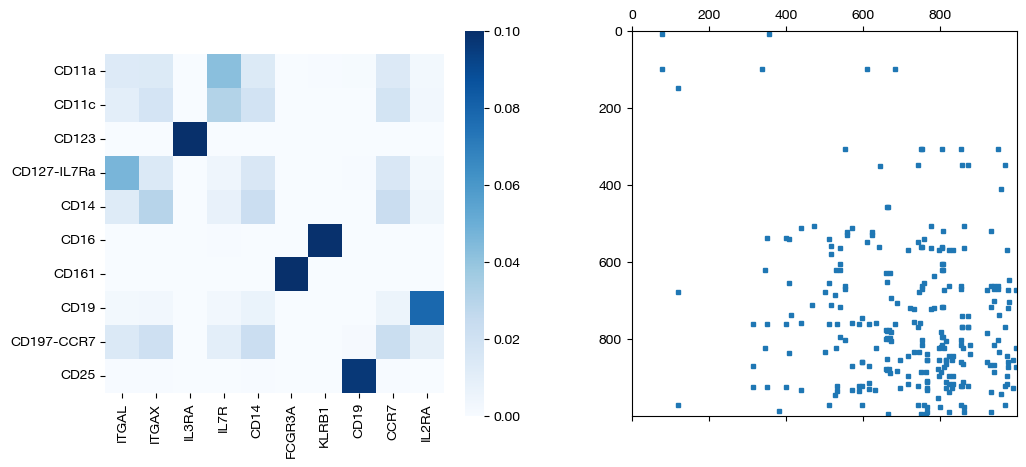

In [46]:
import seaborn as sns

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))

sns.heatmap(pd.DataFrame(pi_feat, index=X_annotated.columns, columns=y_annotated.columns), ax=ax1, cmap='Blues', square=True)
ax2.spy(pi_samp, precision=0.0001, markersize=3)
plt.show()

Note that we used Sinkhorn to generate these coupling matrices, rather than EMD or CG. EMD and CG work very differently to Sinkhorn; we will examine this difference in a later section. For now, we will quickly glance over how entropic regularization and marginal relaxation extend to SCOOTR.

### Entropic Regularization

Entropic regularization functions the same as in prior tutorials, at least when the Sinkhorn option is selected – if you are curious about what entropic regularization does, look at the UGW or UCOOT tutorials. We can quickly show that this similarity holds by experimenting with a few different values of epsilon.

In [10]:
%%capture
(pi_samp_lg, pi_feat_lg), _ = scootr_sink.agw_scootr(X, y, Dx_knn, Dy_knn, alpha=0.1, sample_eps=1, feature_eps=1, sample_uot_mode='sinkhorn', feature_uot_mode='sinkhorn', verbose=True, log=False)

(pi_samp_med, pi_feat_med), _ = scootr_sink.agw_scootr(X, y, Dx_knn, Dy_knn, alpha=0.1, sample_eps=1e-3, feature_eps=1e-3, sample_uot_mode='sinkhorn', feature_uot_mode='sinkhorn', verbose=True, log=False)

(pi_samp_sm, pi_feat_sm), _ = scootr_sink.agw_scootr(X, y, Dx_knn, Dy_knn, alpha=0.1, sample_eps=5e-4, feature_eps=5e-4, sample_uot_mode='sinkhorn', feature_uot_mode='sinkhorn', verbose=True, log=False)

Delta: 0.00044686290929971757  Loss: 0.0657854184174504
Delta: 1.521497299167754e-19  Loss: 0.0657854197468621
converged at iter  5


/Users/colinbaker/anaconda3/envs/scootr/lib/python3.9/site-packages/ot/bregman.py:535: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


Delta: 0.1802288114115536  Loss: 0.055967861688294734
Delta: 0.010965286773727498  Loss: 0.032290710230949406
Delta: 0.21318787281639032  Loss: 0.054730988776610937
Delta: 0.00014830720661730145  Loss: 0.028992096849389463


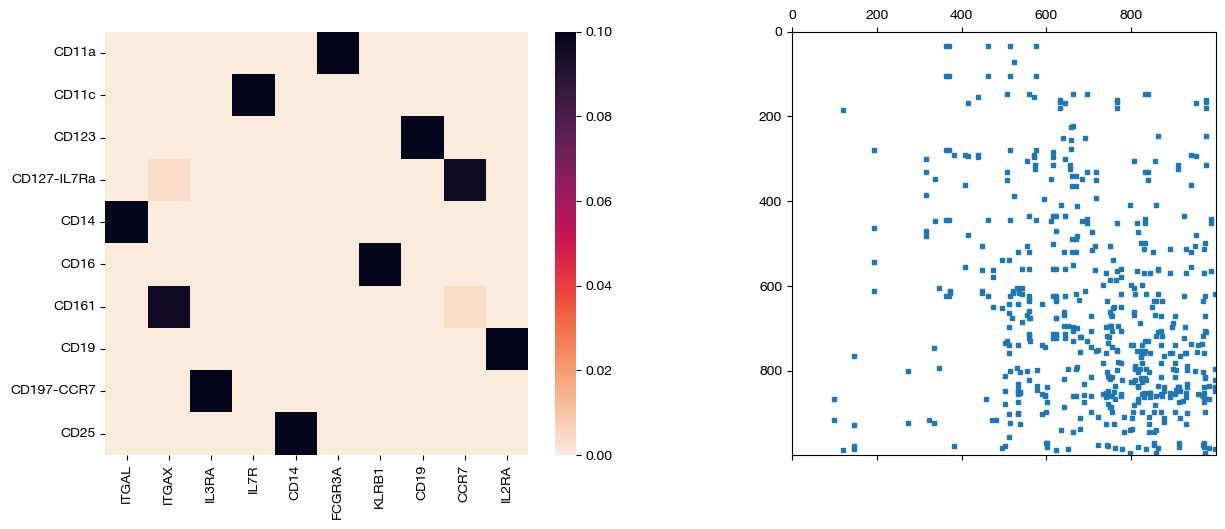

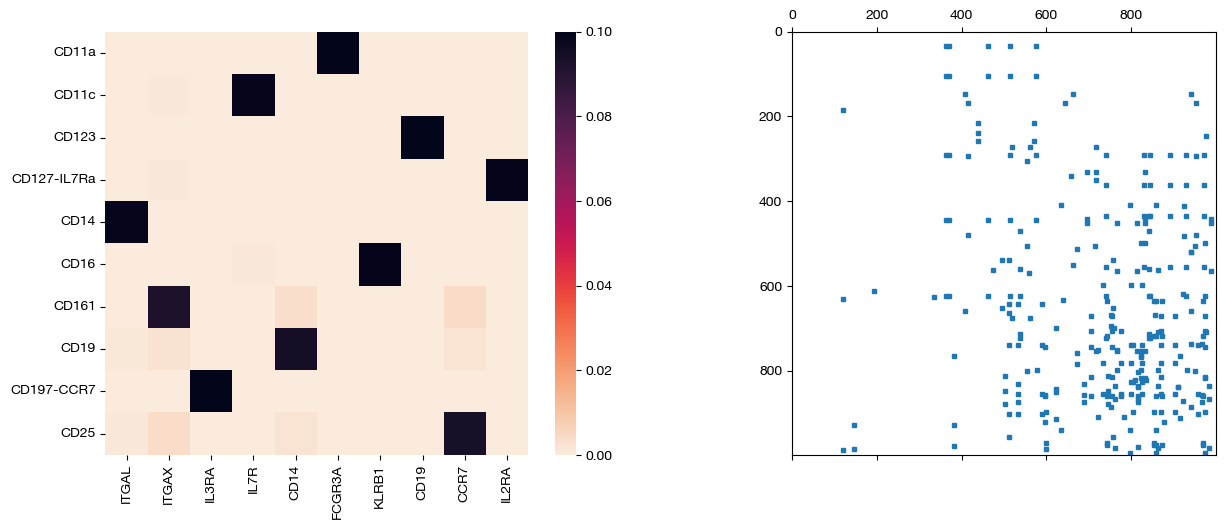

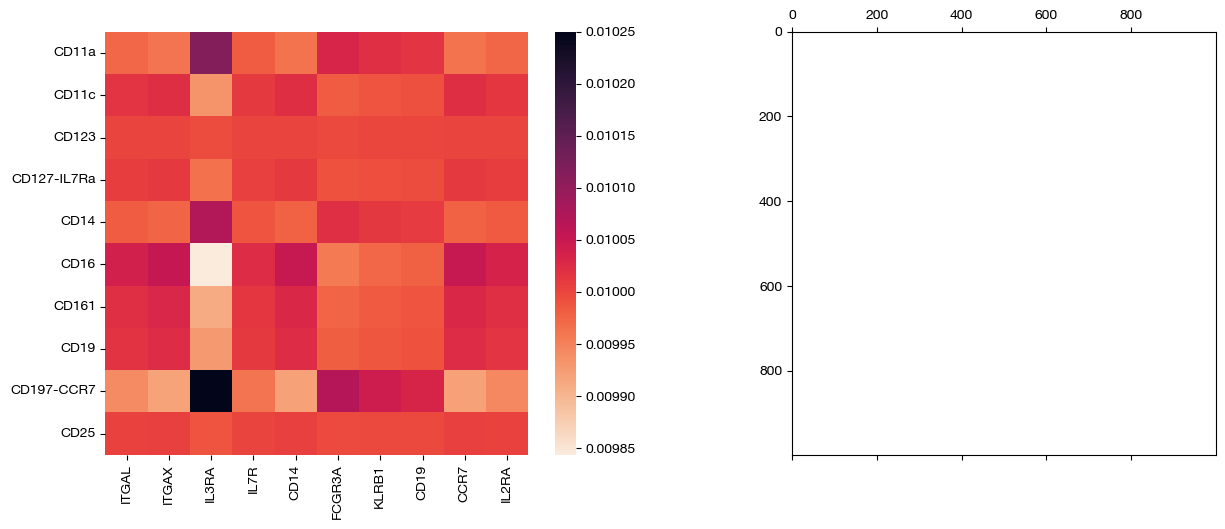

In [82]:
for pi_feat, pi_samp, size in [(pi_feat_sm, pi_samp_sm, 'eps=5e-4'), (pi_feat_med, pi_samp_med, 'eps=1e-3'), (pi_feat_lg, pi_samp_lg, 'eps=1')]:
    
    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))

    sns.heatmap(pd.DataFrame(pi_feat, index=X_annotated.columns, columns=y_annotated.columns), ax=ax1, cmap='Blues', square=True)
    ax2.spy(pi_samp, precision=0.0001, markersize=3)
    plt.show()

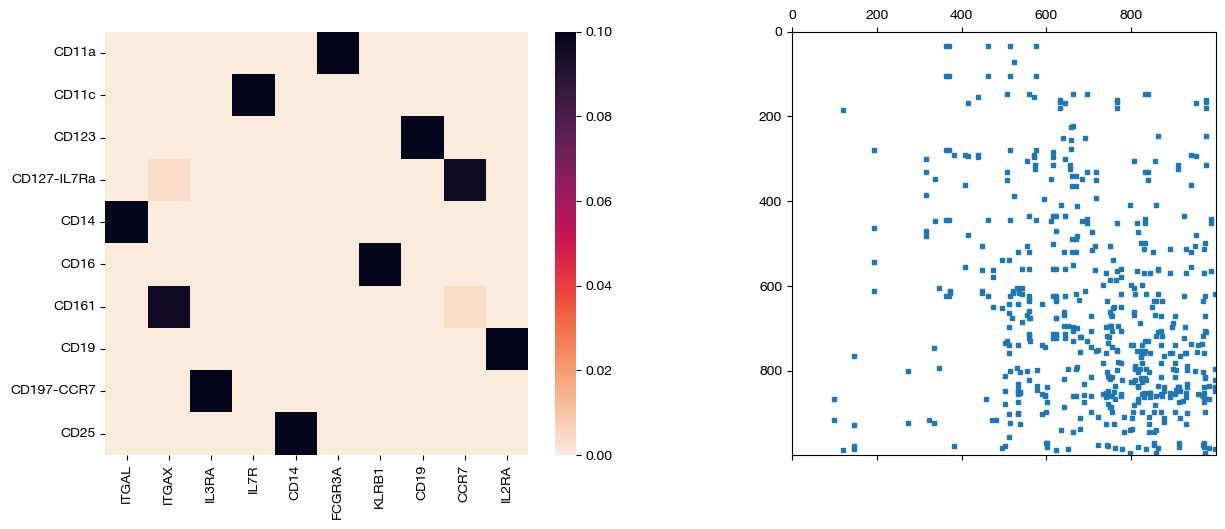

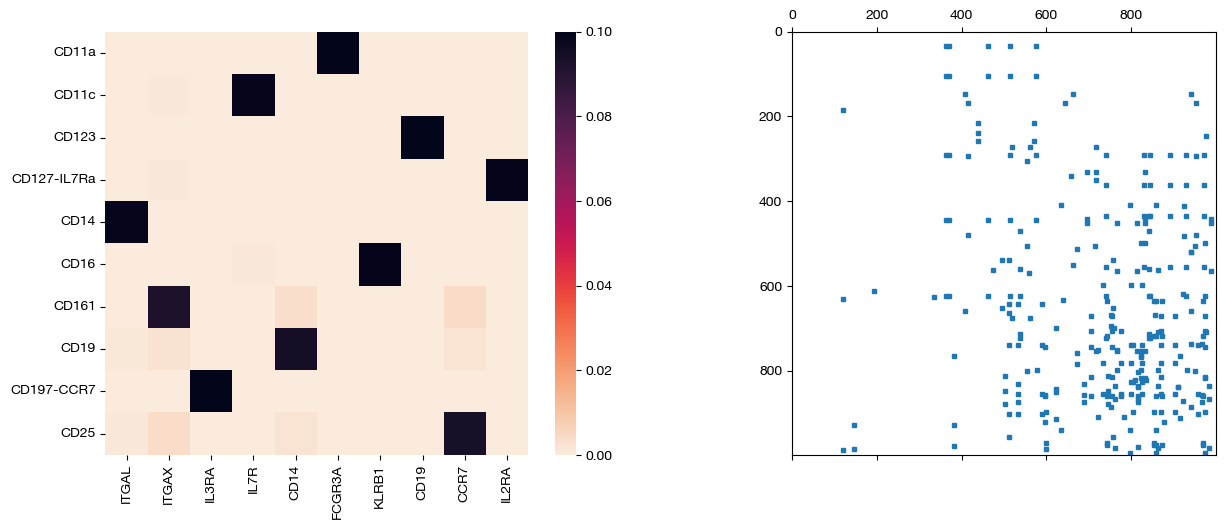

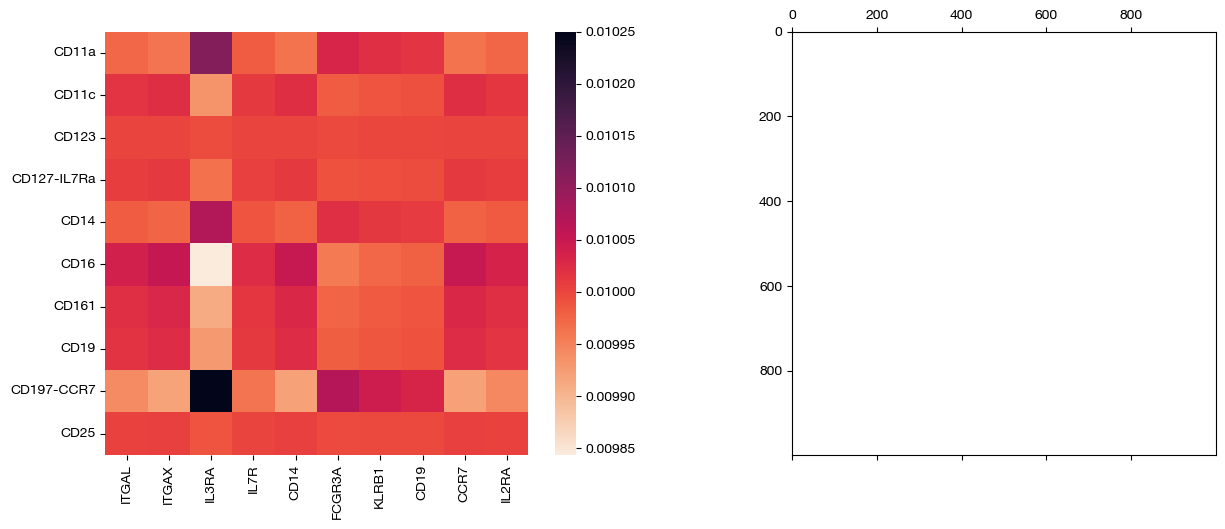

In [62]:
for pi_feat, pi_samp, size in [(pi_feat_sm, pi_samp_sm, 'eps=5e-4'), (pi_feat_med, pi_samp_med, 'eps=1e-3'), (pi_feat_lg, pi_samp_lg, 'eps=1')]:
    
    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    sns.heatmap(pd.DataFrame(pi_feat, index=X_annotated.columns, columns=y_annotated.columns), ax=ax1, cmap='Blues', square=True)
    ax2.spy(pi_samp, precision=0.0001, markersize=3)
    plt.show()

As seen above, high epsilon still encourages density, while a low epsilon leads to more sparse coupling matrices.

```{warning}
While entropic regularization still works as expected for the Sinkhorn option, neither CG nor EMD are entropically regularized at all. They provide significantly more sparse coupling matrices, as we will see later on. If an epsilon value is present and CG/EMD are used for inner OT iterations for one of the coupling matrices, the epsilon value will be ignored when optimizing this coupling matrix.
```

### Marginal Relaxation

Unlike UGW and UCOOT, our current version of SCOOTR does not allow for marginal relaxation. We may add $\rho$ as a hyperparameter in the future, but for the moment, we do not support it. The lack of marginal relaxation in SCOOTR places more emphasis on sample supervision and the initial distributions we use.

### Alpha and Balancing GW and COOT

Now, we can examine SCOOTR closely. We will start by looking at $\alpha$, and then move on to algorithmic decisions and sample/feature supervision.

To start, we will compare the $\alpha = 0$ and $\alpha = 1$ cases to UGW and UCOOT, using the Sinkhorn algorithm (the common algorithm that both SCOOTR and UGW/UCOOT use).

In [100]:
%%capture
(pi_samp_sgw, pi_feat_sgw), _ = scootr_sink.agw_scootr(X, y, Dx_knn, Dy_knn, alpha=1, sample_eps=0.001, feature_eps=0.001, sample_uot_mode='sinkhorn', feature_uot_mode='sinkhorn', verbose=True, log=False)

(pi_samp_ugw, _), duals = scootr_sink.solver_fgw(torch.from_numpy(Dx_knn).to(device), torch.from_numpy(Dy_knn).to(device), eps=0.001, verbose=True, log=False)

(pi_samp_scoot, pi_feat_scoot), _ = scootr_sink.agw_scootr(X, y, Dx_knn, Dy_knn, alpha=0, sample_eps=0.001, feature_eps=0.001, sample_uot_mode='sinkhorn', feature_uot_mode='sinkhorn', verbose=True, log=False)

(pi_samp_ucoot, pi_feat_ucoot), duals = scootr_sink.solver_fcoot(torch.from_numpy(X).to(device), torch.from_numpy(y).to(device), eps=0.001, verbose=True, log=False)

Oddly enough, the coupling matrices are not too similar. In particular, examine the feature coupling matrices from SCOOTR with $\alpha=0$ and UCOOT:

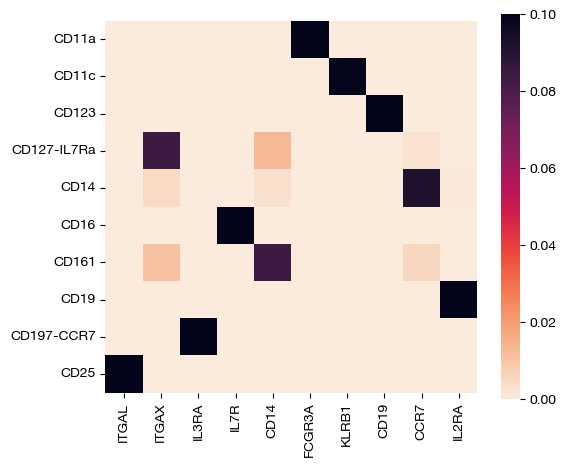

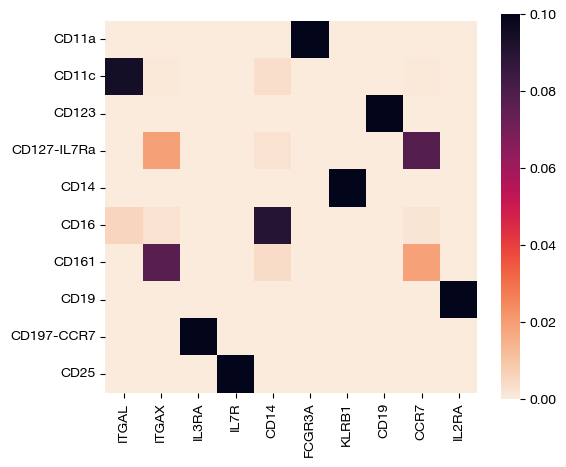

In [101]:
for pi_feat in pi_feat_scoot, pi_feat_ucoot:
    sns.heatmap(pd.DataFrame(pi_feat, index=X_annotated.columns, columns=y_annotated.columns), cmap='Blues', square=True)
    plt.show()

Considering SCOOTR with $\alpha=1$ should be doing the same thing as UCOOT, this is a surprising result. From here, we can look at an intermediate value of $\alpha$, and compare visualizations with $\alpha=0$ and $\alpha=1$

In [14]:
%%capture
(pi_samp_shalf, pi_feat_shalf), _ = scootr_sink.agw_scootr(X, y, Dx_knn, Dy_knn, alpha=0.5, sample_eps=0.001, feature_eps=0.001, sample_uot_mode='sinkhorn', feature_uot_mode='sinkhorn', verbose=True, log=False)

/Users/colinbaker/anaconda3/envs/scootr/lib/python3.9/site-packages/ot/bregman.py:535: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


Delta: 0.18340653838250004  Loss: 0.05673939441886979
Delta: 0.002397163856033941  Loss: 0.03420606718202827


We begin by projecting and scoring these alignments:

In [15]:
aligned_y_sgw = scootr_sink.get_barycentre(X, pi_samp_sgw)
aligned_y_shalf = scootr_sink.get_barycentre(X, pi_samp_shalf)
aligned_y_scoot = scootr_sink.get_barycentre(X, pi_samp_scoot)

Average FOSCTTM score for this alignment (alpha=0) with X onto Y is:  0.5207507507507507


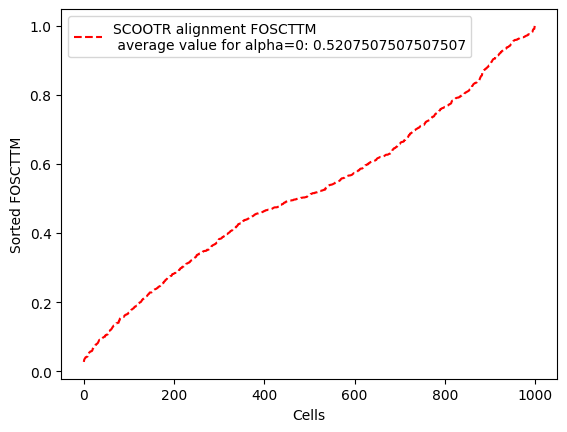

Average FOSCTTM score for this alignment (alpha=0.5) with X onto Y is:  0.5321211211211212


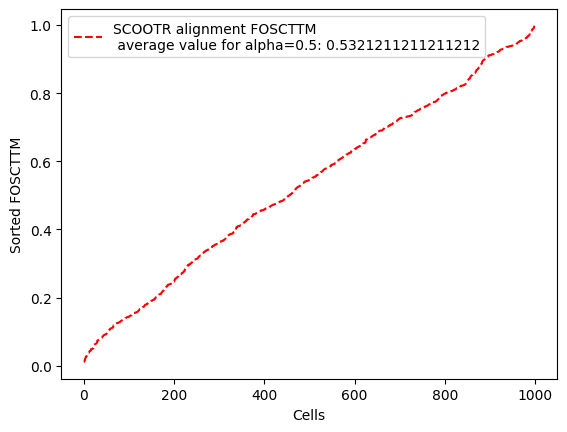

Average FOSCTTM score for this alignment (alpha=1) with X onto Y is:  0.5207507507507507


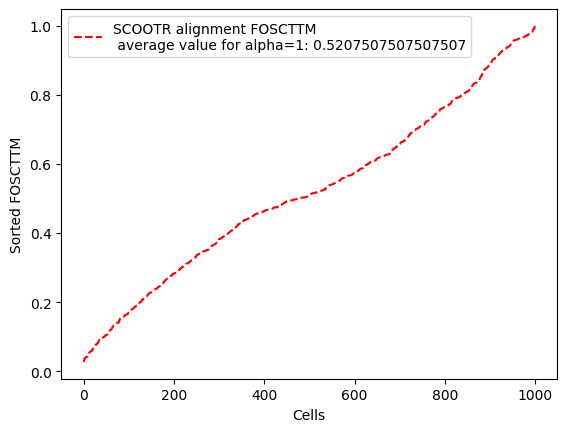

In [16]:
for aligned_y, size in [(aligned_y_scoot, 'alpha=0'), (aligned_y_shalf, 'alpha=0.5'), (aligned_y_scoot, 'alpha=1')]:
    fracs = scootr_sink.calc_domainAveraged_FOSCTTM(X, aligned_y)
    print("Average FOSCTTM score for this alignment ({0}) with X onto Y is:".format(size), np.mean(fracs))
    legend_label="SCOOTR alignment FOSCTTM \n average value for {0}: ".format(size)+str(np.mean(fracs))
    plt.plot(np.arange(len(fracs)), np.sort(fracs), "b--", label=legend_label)
    plt.legend()
    plt.xlabel("Cells")
    plt.ylabel("Sorted FOSCTTM")
    plt.show()

In addition, we can examine the coupling matrices:

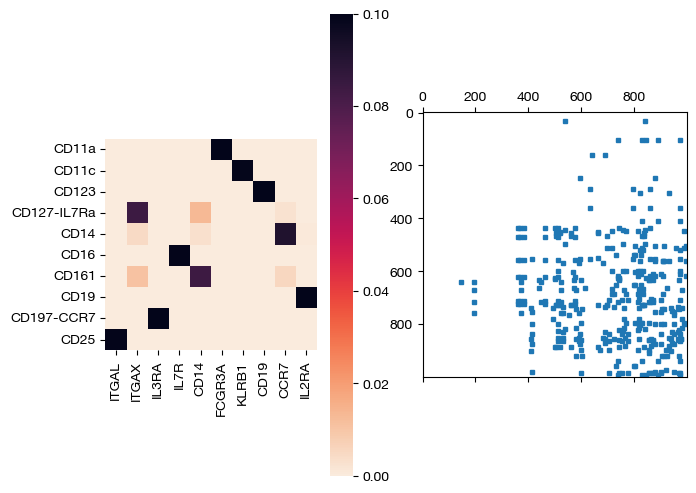

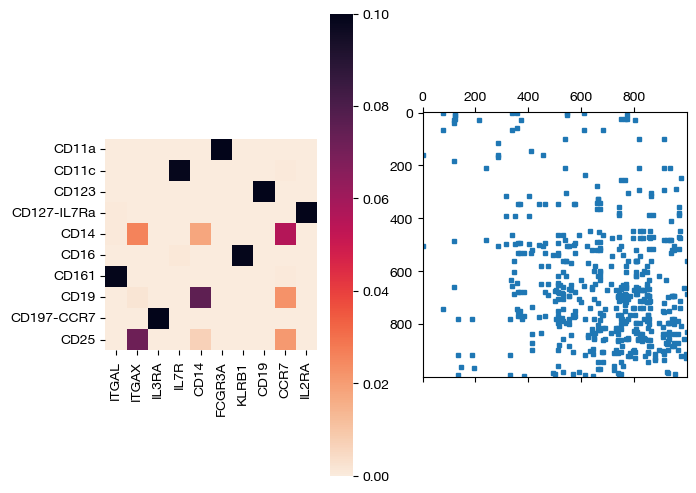

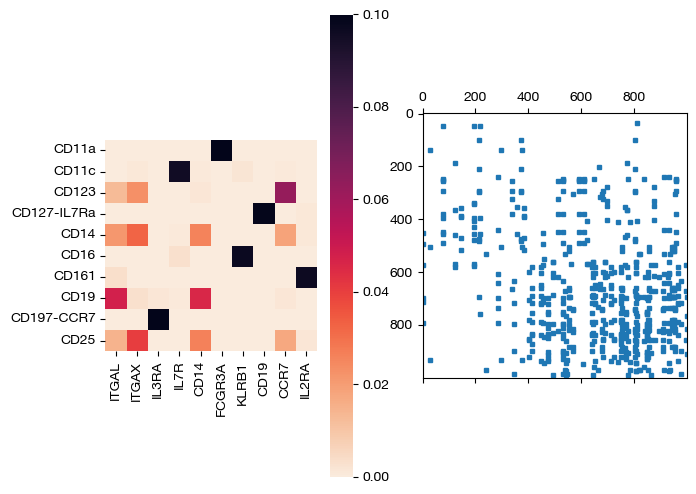

In [84]:
for pi_feat, pi_samp, size in [(pi_feat_scoot, pi_samp_scoot, 'alpha=0'), (pi_feat_shalf, pi_samp_shalf, 'alpha=0.5'), (pi_feat_sgw, pi_samp_sgw, 'alpha=1')]:
    
    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    sns.heatmap(pd.DataFrame(pi_feat, index=X_annotated.columns, columns=y_annotated.columns), ax=ax1, cmap='Blues', square=True)
    ax2.spy(pi_samp, precision=0.0001, markersize=3)
    plt.show()

Note that the middle matrices, $\alpha=0.5$, appear to be somewhere in between the equivalent matrices for $\alpha=0$ and $\alpha=1$. We recommend linearly searching over $\alpha$, as some datasets benefit more from focus on local geometry (high alpha), while some benefit from more focus on feature correspondence (low alpha, when features have strong relationships). As an example:

In [18]:
# an example of alpha search
pi_samp_dt = {}
pi_feat_dt = {}
# for val in np.linspace(start=0, stop=-1, num=10):
    # (pi_samp_dt[val], pi_feat_dt[val]), _ = scootr_sink.agw_scootr(X, y, Dx_knn, Dy_knn, alpha=val, sample_eps=sample_eps, feature_eps=feature_eps, sample_uot_mode=mode, feature_uot_mode=mode, verbose=True, log=False)

From here, we will examine algorithmic decisions with SCOOTR.

### Varying OT Algorithms

While SCOOTR employs the same BCD approach to optimize $\pi_s$ and $\pi_f$ as in UGW/UCOOT, it allows for varying processes to solve BCD's inner OT iterations. As mentioned previously, it allows for conditional gradient descent (CG), earth mover's distance (EMD), and Sinkhorn on the sample side, and EMD and Sinkhorn on the feature side. Recall from earlier that none of these algorithms support marginal relaxation, and only Sinkhorn supports entropic regularization. Here's an example of using each of the different algorithms (via the sample/feature_uot_mode parameters):

```{note}
Recall from earlier that we use a different nits_uot for these three algorithms (via different SCOOTR objects), as their convergence speeds vary significantly.
```

In [22]:
%%capture
(pi_samp_sink, pi_feat_sink), _ = scootr_sink.agw_scootr(X, y, Dx_knn, Dy_knn, alpha=0.1, sample_eps=0.001, feature_eps=0.001, sample_uot_mode='sinkhorn', feature_uot_mode='sinkhorn', verbose=True, log=False)

(pi_samp_emd, pi_feat_emd), _ = scootr_emd.agw_scootr(X, y, Dx_knn, Dy_knn, alpha=0.1, sample_uot_mode='emd', feature_uot_mode='emd', verbose=True, log=False)

(pi_samp_cg, pi_feat_cg), _ = scootr_cg.agw_scootr(X, y, Dx_knn, Dy_knn, alpha=0.1, sample_uot_mode='cg', feature_uot_mode='emd', verbose=True, log=False)

/Users/colinbaker/anaconda3/envs/scootr/lib/python3.9/site-packages/ot/bregman.py:535: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


Delta: 0.1802288114115536  Loss: 0.055967861688294734
Delta: 0.1381751099210415  Loss: 0.03371177733519905
Delta: 0.06139213441089706  Loss: 0.03280633845422998
Delta: 0.024485509748883905  Loss: 0.032591298356219885
Delta: 0.041899991812845795  Loss: 0.0323949370279127
Delta: 0.010965286773727498  Loss: 0.032290710230949406
Delta: 0.0004290554099589873  Loss: 0.032285142987126675
Delta: 3.222118056528758e-05  Loss: 0.032284674067420735
Delta: 5.704590052340071e-06  Loss: 0.032284584098597635
converged at iter  8
Delta: 0.3316069612585049  Loss: 0.051893243528683755
Delta: 0.04315089802078321  Loss: 0.03200710145076164
Delta: 0.03501428280002343  Loss: 0.031986401592236396
Delta: 0.023280893453645635  Loss: 0.03198920629478698
Delta: 0.016613247725836132  Loss: 0.03198014910393914
Delta: 0.013711309200802076  Loss: 0.03197235801415836
Delta: 0.011224972160321816  Loss: 0.0319698010339037
Delta: 0.007483314773547884  Loss: 0.031963066796657814
Delta: 0.0  Loss: 0.031963066796657814
conv

In [23]:
aligned_y_sink = scootr_sink.get_barycentre(X, pi_samp_sink)
aligned_y_emd = scootr_sink.get_barycentre(X, pi_samp_emd)
aligned_y_cg = scootr_sink.get_barycentre(X, pi_samp_cg)

We can score and visualize as usual:

Average FOSCTTM score for this alignment (sinkhorn) with X onto Y is:  0.5333918918918918


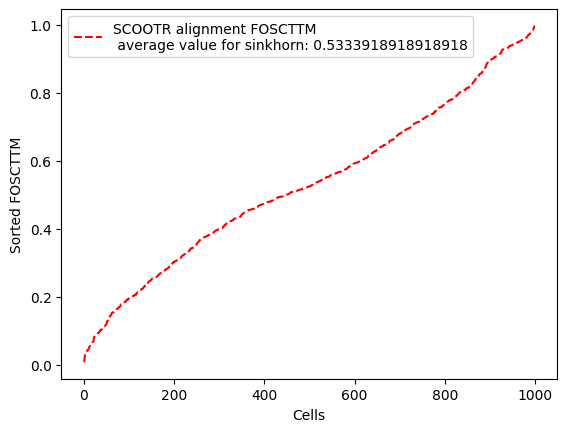

Average FOSCTTM score for this alignment (emd) with X onto Y is:  0.5212527527527527


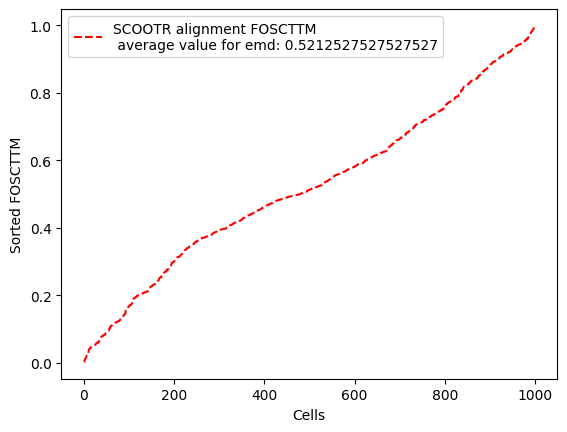

Average FOSCTTM score for this alignment (cg) with X onto Y is:  0.4121321321321321


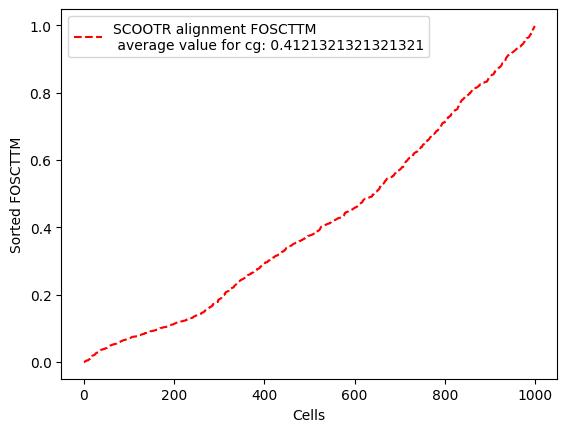

In [24]:
for aligned_y, mode in [(aligned_y_sink, 'sinkhorn'), (aligned_y_emd, 'emd'), (aligned_y_cg, 'cg')]:
    fracs = scootr_sink.calc_domainAveraged_FOSCTTM(X, aligned_y)
    print("Average FOSCTTM score for this alignment ({0}) with X onto Y is:".format(mode), np.mean(fracs))
    legend_label="SCOOTR alignment FOSCTTM \n average value for {0}: ".format(mode)+str(np.mean(fracs))
    plt.plot(np.arange(len(fracs)), np.sort(fracs), "b--", label=legend_label)
    plt.legend()
    plt.xlabel("Cells")
    plt.ylabel("Sorted FOSCTTM")
    plt.show()

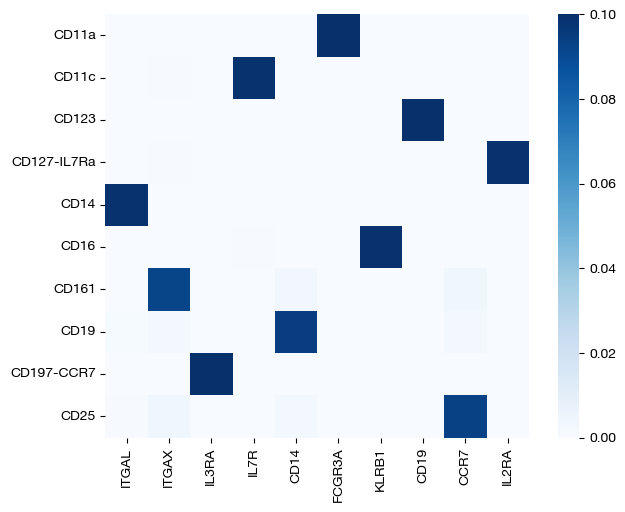

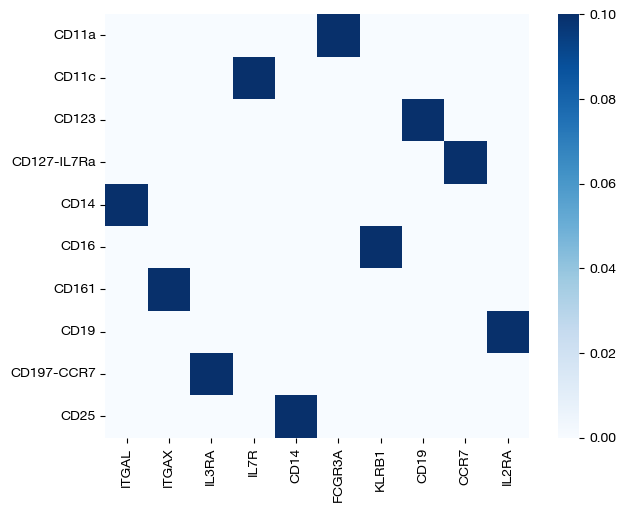

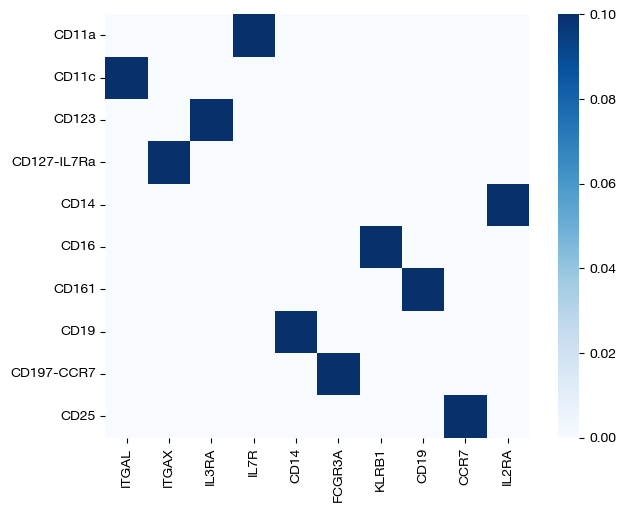

In [96]:
for pi_feat, pi_samp, mode in [(pi_feat_sink, pi_samp_sink, 'sink'), (pi_feat_emd, pi_samp_emd, 'emd'), (pi_feat_cg, pi_samp_cg, 'cg')]:
    
    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))

    sns.heatmap(pd.DataFrame(pi_feat, index=X_annotated.columns, columns=y_annotated.columns), ax=ax1, cmap='Blues', square=True)
    ax2.spy(pi_samp, precision=0.0001, markersize=3)
    plt.show()

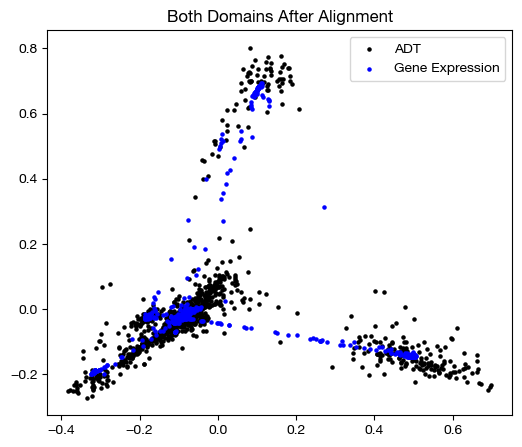

In [98]:
pca=PCA(n_components=2)
Xy_pca=pca.fit_transform(np.concatenate((X, aligned_y_sink), axis=0))
X_pca=Xy_pca[0:1000,]
y_pca=Xy_pca[1000:,]

# Plot aligned domains, samples colored by domain identity:
plt.scatter(X_pca[:,0], X_pca[:,1], c="k", s=5, label="ADT")
plt.scatter(y_pca[:,0], y_pca[:,1], c="b", s=5, label="Gene Expression")
plt.legend()
plt.show()

Hopefully, these examples give you a sense of how to use Sinkhorn, CG, and EMD. CG and EMD seek to solve the exact same inner OT problem, while Sinkhorn seeks to solve this same problem as $\epsilon \to 0$. We recommend trying out each approach for your data; in this case, we can see that CG performs the best. Now, we move on to supervision.

### Supervision (Extension of Fused Formulation to SCOOTR)

*THIS SECTION IS STILL UNDER DEVELOPMENT*

In one of our application notebooks, we examine potential ways to generate sample and feature supervision matrices given cell types (sample supervision) prior knowledge (feature supervision).

We have now concluded the SCOOTR tutorial. The key differences between SCOOTR and UCOOT/UGW are:

1. SCOOTR uses $\alpha$ to denote the GW/COOT balance, rather than a supervision coefficient.
2. SCOOTR allows for conditional gradient descent and earth mover's distance for inner OT iterations on the sample matrix, and earth mover's distance for inner OT iterations on the feature matrix. It does not support the majorization-minimization algorithm.
3. SCOOTR does not allow for marginal relaxation, and only allows for entropic regularization when Sinkhorn is the selected algorithm.
4. SCOOTR brings together GW/COOT simultaneously to improve alignment quality and account for both feature correspondence as well as local geometry.

Now that you have reached this stage, we recommend viewing our application notebooks! These tutorials have attempted to help give you intuition for the parameters, algorithms, etc., but they do not display well what to do in practice on unpaired datasets and how to score these circumstances. Continue on to learn more about how SCOOTR can better align your data.

Citations:

Pinar Demetci, Quang Huy Tran, Ievgen Redko, Ritambhara Singh. Revisiting invariances and introducing priors in Gromov-Wasserstein distances. arXiv, stat.ML, 2023.